## Introduction

In this tutorial, we demonstrate how to use autoencoer (AE) on EMT dataset. The EMT dataset is time-series scRNA-seq dataset from an A549 cancer cell line where cells were exposed to TGFB1 to induce EMT at the first five time points [1].

We used the standard Seurat protocol for data preprocessing. The raw count matrix is selected via quality control, and the total count of each cell is normalized. The normalized count matrix is then log-transformed to log expression. The top $3000$ highly variable genes are selected for EMT dataset, where $n_{input}=3000$ is the input dimension for AE.

References:
1. Cook, D.P. and B.C. Vanderhyden, Context specificity of the EMT transcriptional response. Nature communications, 2020. 11(1): p. 2142

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context
import os
from pathlib import Path
import matplotlib.pyplot as plt
import gc
import sys
sys.path.append('Path to AE folder')
from AE import AutoEncoder, Trainer


def load_data(dataset:str,path_to_data):

    if dataset=='EMT':
        data = pd.read_csv(path_to_data+'AE_EMT_normalized.csv', index_col=0).transpose()
        y = pd.read_csv(path_to_data+'AE_EMT_time.csv', index_col=0)
        row_order = data.index
        y_reordered = y.loc[row_order]
        adata = sc.AnnData(data)
        adata.obs['time'] = y_reordered


        X=adata.X
    elif dataset=='iPSC':
        filename = path_to_data+'data.xlsx'
        df = pd.read_excel(filename, header=[0, 1], index_col=0)
        times = df.columns.get_level_values(0)
        times = times.to_list()
        df.columns = df.columns.droplevel(0)
        df = df.transpose()
        adata = sc.AnnData(df)
        adata.obs['time'] = times

        X=adata.X

    else:
        raise NotImplementedError
    return adata,X
def folder_dir(dataset:str='EMT',
         seed:int=42,
         n_latent:int=6,
         n_hidden:int=300,
         n_layers: int=1,
         activation: str = 'relu',
         dropout:float=0.2,
         weight_decay:float=1e-4,
         lr:float=1e-3,
         batch_size: int=32,):
    folder=Path('results/'+dataset+'_'+str(seed)+\
           '_'+str(n_latent)+'_'+str(n_layers)+'_'+str(n_hidden)+\
           '_'+str(dropout)+'_'+str(weight_decay)+'_'+str(lr)+'_'+str(batch_size)+'/')
    return folder
def generate_plots(folder,model, adata,seed,n_neighbors=10,min_dist=0.5,plots='umap'):
    model.eval()
    with torch.no_grad():
        X_latent_AE=model.get_latent_representation(torch.tensor(adata.X).type(torch.float32).to('cpu'))
    adata.obsm['X_AE']=X_latent_AE.detach().cpu().numpy()
    sc.pp.neighbors(adata, n_neighbors=n_neighbors,use_rep='X_AE')

    if dataset in ['EMT','iPSC']:
        color=['time']
    else:
        raise  NotImplementedError
    if plots=='umap':
        sc.tl.umap(adata,random_state=seed,min_dist=min_dist)
        with rc_context({'figure.figsize': (8, 8*len(color))}):
            sc.pl.umap(adata, color=color,
                       legend_loc='on data',
                       legend_fontsize=12,
                       legend_fontoutline=2, )
        plt.savefig(str(folder) + '/umap.pdf')
        plt.close()
    elif plots=='embedding':
        with rc_context({'figure.figsize': (8*len(color), 8)}):
            sc.pl.embedding(adata, 'X_AE',color=color,
                       # legend_loc='on data',
                       legend_fontsize=12,
                       legend_fontoutline=2, )
            plt.legend(frameon=False)
            plt.xticks([plt.xlim()[0], 0., plt.xlim()[1]])
            plt.yticks([plt.ylim()[0], 0., plt.ylim()[1]])
        plt.savefig(str(folder) + '/embedding.pdf')
        plt.close()

def loss_plots(folder,model):
    fig,axs=plt.subplots(1, 1, figsize=(4, 4))
    axs.set_title('AE loss')
    axs.plot(model.history['epoch'], model.history['train_loss'])
    axs.plot(model.history['epoch'], model.history['val_loss'])
    plt.yscale('log')
    axs.legend(['train loss','val loss'])
    plt.savefig(str(folder)+'/loss.pdf')
    plt.close()

def main(dataset:str='EMT',
         seed:int=42,
         n_latent:int=6,
         n_hidden:int=300,
         n_layers: int=1,
         activation: str='relu',
         dropout:float=0.2,
         weight_decay:float=1e-4,
         lr:float=1e-3,
         max_epoch:int=500,
         batch_size: int=32,
         mode='training',
         path_to_data='Path to data'
         ):
    adata,X = load_data(dataset,path_to_data)

    model=AutoEncoder(in_dim=X.shape[1],
                      n_latent=n_latent,
                      n_hidden=n_hidden,
                      n_layers=n_layers,
                      activate_type=activation,
                      dropout=dropout,
                      norm=True,
                      seed=seed,)

    trainer=Trainer(model,X=X,
                    test_size=0.1,
                    lr=lr,
                    batch_size=batch_size,
                    weight_decay=weight_decay,
                    seed=seed)

    folder=folder_dir(dataset=dataset,
         seed=seed,
         n_latent=n_latent,
         n_hidden=n_hidden,
         n_layers=n_layers,
         dropout=dropout,
         activation=activation,
         weight_decay=weight_decay,
         lr=lr,
         batch_size=batch_size,)

    if mode=='training':
        print('training the model')
        trainer.train(max_epoch=max_epoch,patient=30)

        # model.eval()
        if not os.path.exists(folder):
            folder.mkdir(parents=True)
        torch.save({
            'func_state_dict': model.state_dict(),
            'optimizer_state_dict': trainer.optimizer.state_dict(),
            'loss_history':trainer.model.history,
        }, os.path.join(folder,'model.pt'))
    elif mode=='loading':
        print('loading the model')
        check_pt = torch.load(os.path.join(folder, 'model.pt'))

        model.load_state_dict(check_pt['func_state_dict'])
        trainer.optimizer.load_state_dict(check_pt['optimizer_state_dict'])
        model.history=check_pt['loss_history']
    return model,trainer,adata,folder




Here we consider the dimension of latent space is 10.

training the model
Epoch 0: train loss = 1.5883, val error = 1.0675
Epoch 1: train loss = 1.4650, val error = 1.0482
Epoch 2: train loss = 1.3916, val error = 0.9731
Epoch 3: train loss = 1.3279, val error = 0.8703
Epoch 4: train loss = 1.2703, val error = 0.8673
Epoch 5: train loss = 1.2146, val error = 0.8090
Epoch 6: train loss = 1.1619, val error = 0.7698
Epoch 7: train loss = 1.1121, val error = 0.7850
Epoch 8: train loss = 1.0656, val error = 0.7310
Epoch 9: train loss = 1.0206, val error = 0.6548
Epoch 10: train loss = 0.9765, val error = 0.6842
Epoch 11: train loss = 0.9363, val error = 0.6700
Epoch 12: train loss = 0.8962, val error = 0.6015
Epoch 13: train loss = 0.8598, val error = 0.5958
Epoch 14: train loss = 0.8235, val error = 0.5603
Epoch 15: train loss = 0.7886, val error = 0.5173
Epoch 16: train loss = 0.7563, val error = 0.5227
Epoch 17: train loss = 0.7243, val error = 0.5072
Epoch 18: train loss = 0.6952, val error = 0.4802
Epoch 19: train loss = 0.6657, val error 

/Users/yutong/Documents/revison_environment/TIGON/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/yutong/Documents/revison_environment/TIGON/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/yutong/Documents/revison_environmen

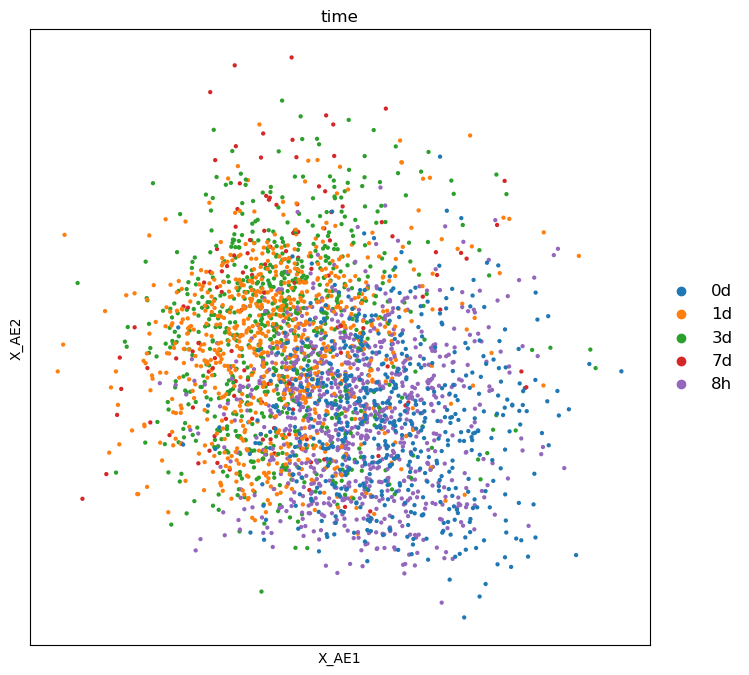

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [2]:
seed=4232
n_layers = 1
batch_size=128


dataset='EMT'

lr=1e-3
n_hidden=300
n_latent = 10


model,trainer, adata,folder=main(dataset=dataset,seed=seed,
                          n_layers=n_layers,n_latent=n_latent,n_hidden=n_hidden,
                          activation='relu',
                          lr=lr,batch_size=batch_size,
                          max_epoch=500,
                          mode='training',
                          path_to_data = 'Path to data')

model=model.to('cpu')

generate_plots(folder,model, adata,seed,n_neighbors=20,min_dist=0.5,plots='embedding')
loss_plots(folder,model)
